#### Setup

In [1]:
# imports
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
from numpy import exp, sqrt
import os

import importlib.util

# import helper functions
from boltzmann import decode, encode
from boltzmann import calculate_statistics, calculate_statistics_ram_friendlier

In [2]:
# setup figures
FIG_DIR = 'figures/'
plt.rcParams["figure.figsize"] = (10, 4.5)
plt.rcParams["savefig.format"] = "pdf"
plt.rcParams["savefig.dpi"] = 400
plt.rcParams["savefig.transparent"] = True
plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams.update({'font.size': 14.5}) # does not seem to work otherwise

#### Create working directories

In [3]:
for path in [FIG_DIR]:
    if not os.path.exists(path):
        os.makedirs(path)

#### Metropolis-Hastings MCMC sampler

For this Notebook the sampler implemented in either Python or C++ can be used. The sampler written in C++ is only used for the inference of the actual Salamander retina data, not for the preliminairy experiments.  

The block below will compile the C++ sampler, which can be ommitted if prefered. 

In [4]:
!python3 setup.py build

running build
running build_ext


**This should create a file like `build/lib.linux-x86_64-3.6/Worker.cpython-36m-x86_64-linux-gnu.so` or `build/lib.macosx-10.14-x86_64-3.7/Worker.cpython-37m-darwin.so`.  
Please provide the correct name below!**

In [5]:
# provide correct path here
os.environ['COMPILED_WORKER_PATH'] = "build/lib.macosx-10.14-x86_64-3.7/Worker.cpython-37m-darwin.so"
use_cpp_sampler = True
num_cpp_threads = 8

# generate random couplings and biases
N = 160
w = np.random.uniform(low=-0.1, high=0.2, size=(N,N))
w = (w + w.T) / 2 # symmetrize couplings
np.fill_diagonal(w, 0) # set coupling to self to zero
h = np.random.uniform(low=-0.1, high=0.0, size=N) # biases

if use_cpp_sampler:
    try:
        # test C++ sampler
        m_est, S2_est = calculate_statistics(w, h, N, num_samples=int(1e4), cpp_sampler=True, 
                                             num_threads=num_cpp_threads, verbose=False)

        # sampler works
        use_cpp_sampler = True
        print("Using C++ sampler")
    except:
        # neither sampler work
        use_cpp_sampler = False
        print("Using python sampler")

Using C++ sampler


# Boltzmann Machine Learning

This notebook is adapted from the exercise on Boltzmann Machine Learning of the Advanced Machine Learning course by Bert Kappen, http://www.snn.ru.nl/~bertk/machinelearning/adv_ml.html. The components in this document were used to answer the questions, http://www.snn.ru.nl/~bertk/machinelearning/bm_exercise_adv.pdf, but also provide additional analysis.  

A writeup about this exercise is available here: [TODO]

This exercise investigates a Boltzmann network with a single, visible layer and no hidden layer. The neurons in this model are fully connected.  

The learning rules are given in the handout, http://www.snn.ru.nl/~bertk/machinelearning/handouts_ml.pdf, Chapter 2 page 21:  

$$
\frac{\partial L}{\partial \theta_i}
=
\left(\langle s_i \rangle _c - \langle s_i \rangle \right)
$$
and
$$
\frac{\partial L}{\partial w_{ij}}
=
\left(\langle s_is_j \rangle _c − \langle s_is_j \rangle \right),\  i \neq j 
$$

# Part 1: exact computation of statistics
For small systems the statistics can be calculated exactly, as has been done in exercise 2 of the handout. Here the equations are more general, though, for we do not have identical weights nor a bias equal to the couplings.  

Let $N = 12$, then we have $\mathcal{O}(10^4)$ calculations, which can easily be calculated. The Ising Model, of which a Boltzmann Machine is an extension, is governed by the following probabilities for each state:  
$$
\begin{align}
-E(s) &= \frac{1}{2}\sum_{ij} w_{ij} s_is_j + \sum_i \theta_is_i\\
Z &= \sum_{s} \exp(-E(s))\\
p(s) &= \frac{1}{Z} \exp(-E(s)) = \frac{1}{Z} \exp\left( \frac{1}{2}\sum_{ij} w_{ij} s_is_j + \sum_i \theta_is_i\right)
\end{align}
$$

For small systems these joint probabilities can be calculated exactly, as the normalization $Z$ covering $2^N$ terms is still tractible. 

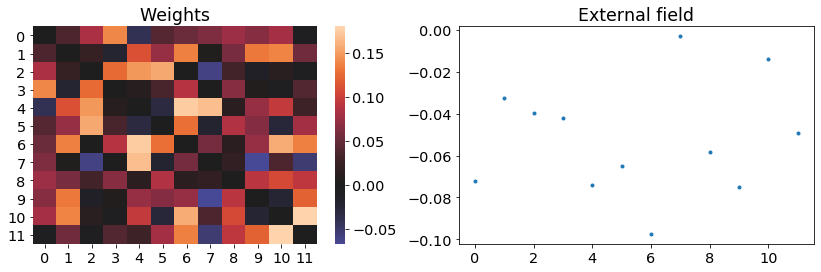

In [6]:
# generate random couplings and external field
np.random.seed(576)

N = 12
# generate random couplings and biases
w = np.random.uniform(low=-0.1, high=0.2, size=(N,N))
w = (w + w.T) / 2 # symmetrize couplings
np.fill_diagonal(w, 0) # set coupling to self to zero
h = np.random.uniform(low=-0.1, high=0, size=N) # biases

f, axes = plt.subplots(1, 2, figsize=(14,4))
ax = axes[0]
sns.heatmap(w, center=0, ax=ax)
ax.set_title("Weights")

ax = axes[1]
ax.plot(np.arange(len(h)), h, '.')
ax.set_title("External field")
plt.show()

In [7]:
# calculate E, Z and p
def calc_negE_Z_p(states, w, h):
    W = np.matrix(w)
    negE = np.zeros(len(states))
    for i, s in enumerate(states):
        S = np.matrix(s)
        # s contains e.g. [1, 0, 1, ..., 0, 1, 1]
        # calculate -E(s)
        negE[i] = 0.5 * np.sum(S*W*S.T) + np.sum(h*s)
        # # np.sum(w*s*s) calculates the same as:
        # a = 0
        # for k in range(N):
        #     for j in range(N):
        #         a += 0.5*w[k, j] * s[k] * s[j]
        # a += np.sum(h*s)
        # if a != negE[i]:
        #     print(a, negE[i], a-negE[i])
        # but then faster
    
    # calculate normalization constant
    Z = np.sum(np.exp(negE))

    # calculate probabilities of states
    p = 1/Z * np.exp(negE)

    return negE, Z, p

# calculate Z and p
states = decode(np.arange(2**N), N=N) # list of all possible states
negE, Z, p = calc_negE_Z_p(states, w, h)

## Calculate exact mean firing rate
The mean firing rate is the expectation value of the neuron under probability distribution $p$:  
$$m_i = \langle s_i\rangle = \sum_s s_ip(s)
$$

[-0.12721511 -0.12125121 -0.09974655 -0.0993985  -0.1387976  -0.13289791
 -0.18304032 -0.02591794 -0.12681723 -0.14139293 -0.10274586 -0.12896782]


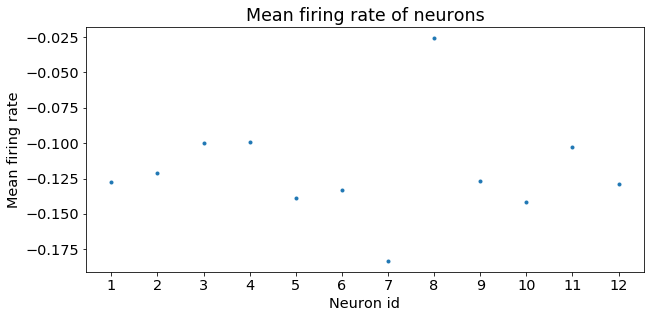

In [8]:
def calc_mfr(states, p):
    m = np.zeros(N)
    for statenum, s in enumerate(states):
        # calculate mean firing rate of neuron i
        m += s * p[statenum]
    return m

negE, Z, p = calc_negE_Z_p(states, w, h)
m = calc_mfr(states, p)
print(m)
# visual representation
f, ax = plt.subplots(1, 1)
ax.plot(np.arange(len(m))+1, m, '.'); ax.set_xlabel("Neuron id")
ax.set_ylabel("Mean firing rate"); ax.set_title("Mean firing rate of neurons")
ax.set_xticks(np.arange(len(m))+1)
plt.show()

## Calculate exact correlation
The correlation between two neurons is given by:  
$$
\chi_{ij} = \langle s_is_j \rangle - \langle s_i \rangle \langle s_j \rangle =
\sum_s s_is_jp(s) − m_im_j
$$

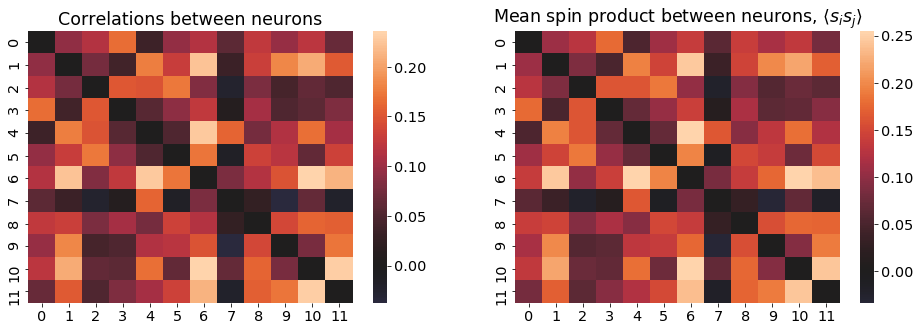

In [9]:
def calc_Esisj(states, p):
    N = states.shape[1] # number of neurons
    S2 = np.zeros((N,N))
    for i in range(N):
        for j in range(i, N): # only calculate half, symmetric
            for statenum, s in enumerate(states):
                S2[i,j] += s[i] * s[j] * p[statenum]
            # symmetric in swapping i <-> j
            S2[j,i] = S2[i,j]
    return S2

def calc_corr(states, p):
    N = states.shape[1] # number of neurons
    X = np.zeros((N, N))
    for i in range(N):
        for j in range(i, N): # only calculate half, for correlations are symmetric
            if i == j: continue
            # calculate sum of s_i s_j p(s)
            for statenum, s in enumerate(states):
                X[i,j] += s[i] * s[j] * p[statenum]
            # substract mean firing rates
            X[i, j] -= m[i] * m[j]
            # copy to symmetric part
            X[j, i] = X[i, j] # can also ommit this part and change 
            # range(i, N) to range(0, N) and obtain the same result
    return X

X = calc_corr(states, p)

f, axes = plt.subplots(1, 2, figsize=(16, 5))
ax = axes[0]
sns.heatmap(X, center=0, ax=ax)
ax.set_title("Correlations between neurons")

ax = axes[1]
ss = calc_Esisj(states, p)
np.fill_diagonal(ss, 0)
sns.heatmap(ss, center=0, ax=ax)
ax.set_title(r"Mean spin product between neurons, $\langle s_i s_j \rangle$")
plt.show()

## Generate toy data set
Generate a set of P training patters: $s^\mu = (s_1^\mu, ..., s_n^\mu)$, with $\mu = 1, ..., P$. We want to describe the dynamics of this training set using the Boltzmann Machine Learning rules. To achieve this, we will minimize the likelihood of observing these samples:  
$$L(w, \theta) = \frac{1}{P} \sum_\mu \log p(s_1^\mu, ..., s_n^\mu)$$

Minimizing the likelihood w.r.t. the couplings and thresholds yields the learning rules stated at the start. 

Shape of spikes:  (12, 1000)


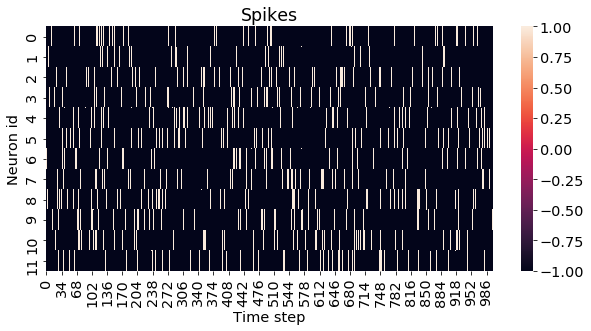

In [10]:
# generate random data set
P = 1000 # number of 'measurements'
spikes = np.random.poisson(lam=0.1, size=(N,P))
spikes[spikes > 1] = 1
spikes[spikes == 0] = -1
print("Shape of spikes: ", spikes.shape)

f, ax = plt.subplots(1, 1)
sns.heatmap(spikes, ax=ax)
ax.set_title("Spikes")
ax.set_xlabel("Time step")
ax.set_ylabel("Neuron id")
plt.show()

## Calculate the 'clamped' statistics
$$
\begin{align}
\langle s_i \rangle_c &= \frac{1}{P} \sum_\mu s_i^\mu\\
\langle s_i s_j \rangle_c &= \frac{1}{P} \sum_\mu s_i^\mu s_j^\mu
\end{align}
$$

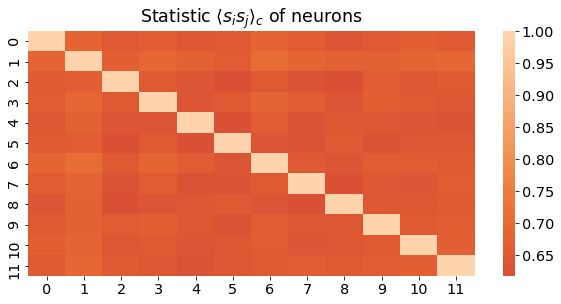

Clamped mean firing rates: 
 [-0.812 -0.846 -0.8   -0.816 -0.79  -0.794 -0.818 -0.804 -0.794 -0.806
 -0.808 -0.816]


In [11]:
# calculate clamped mean firing rate
m_c = 1/P * np.sum(spikes, axis=1)

# calculate clamped correlations
S2_c = np.zeros((N, N))
for i in range(N):
    for j in range(i, N): # only calculate half, for correlations are symmetric
        if i == j: pass
        # calculate sum of s_i s_j of samples
        S2_c[i, j] = np.sum(spikes[i,:] * spikes[j,:]) / P
        # copy to symmetric part
        S2_c[j, i] = S2_c[i, j] # can also ommit this part and change 
        # range(i, N) to range(0, N) and still obtain the same result

f, ax = plt.subplots(1, 1)
sns.heatmap(S2_c, center=0, ax=ax)
ax.set_title(r"Statistic $\langle s_i s_j \rangle_c$ of neurons")
plt.show()

print("Clamped mean firing rates: \n", m_c)

## Perform Boltzmann Machine Learning (gradient ascent)
With the partial derivatives of the likelihood:  
$$
\begin{align}
\frac{\partial L}{\partial \theta_i} &= \left(\langle s_i \rangle _c - \langle s_i \rangle \right)\\
\frac{\partial L}{\partial w_{ij}} &= \left(\langle s_is_j \rangle _c − \langle s_is_j \rangle \right),\ i \neq j
\end{align}
$$

We obtain parameter updates:  
$$
\begin{align}
w_{ij}(t + 1) &= w_{ij}(t) + \eta \frac{\partial L}{\partial w_{ij}} = w_{ij}(t) + \eta \left(\langle s_is_j \rangle _c − \langle s_is_j \rangle \right),\ i \neq j\\
\theta_i(t + 1) &= \theta_i(t) + \eta \frac{\partial L}{\partial \theta_i} = \theta_i(t) + \eta \left(\langle s_i \rangle _c - \langle s_i \rangle \right)
\end{align}
$$

Of which the clamped statistics have been calculated above, and the 'free' statistics have to be calculated after each parameter update. 

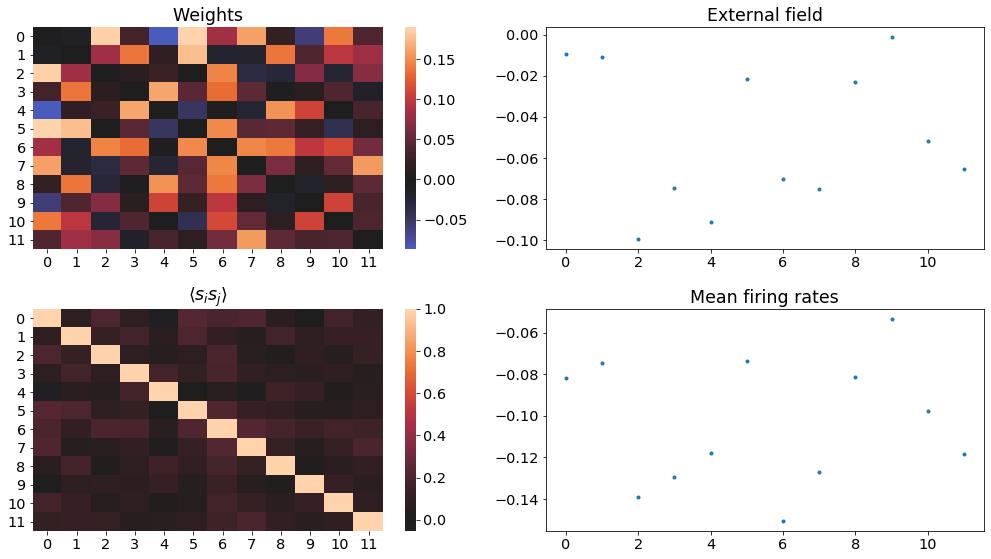

In [12]:
# generate random couplings and biases
w = np.random.uniform(low=-0.1, high=0.2, size=(N,N))
w = (w + w.T) / 2 # symmetrize couplings
np.fill_diagonal(w, 0) # set coupling to self to zero
h = np.random.uniform(low=-0.1, high=0.0, size=N) # biases

_, _, p = calc_negE_Z_p(states, w, h)

f, axes = plt.subplots(2, 2, figsize=(14, 8))
ax = axes[0, 0]
sns.heatmap(w, center=0, ax=ax)
ax.set_title("Weights")

ax = axes[0, 1]
ax.plot(np.arange(len(h)), h, '.')
ax.set_title("External field")

ax = axes[1, 0]
sns.heatmap(calc_Esisj(states, p), center=0, ax=ax)
ax.set_title(r"$\langle s_is_j \rangle$")

ax = axes[1, 1]
ax.plot(calc_mfr(states, p), '.')
ax.set_title("Mean firing rates")

f.tight_layout()
plt.show()

L, w_updates, h_updates = [], [], []

In [13]:
def loglikelihood(data, w, h):
    """Calculate log likelihood of observing the data as defined in the handout:
    logL = 1/P sum over samples of p(state)
    Note: this method assumes the states and p variable are calculated in advance!!!"""
    state_nums = encode(states, N=N)
    spike_nums = encode(data.T, N=N)
    
    logL = 0
    for num in spike_nums:
        # pi = probability of state s
        pi = p[num]
        logL += np.log(pi)
    return logL / len(data)

L=-0.04254: 100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


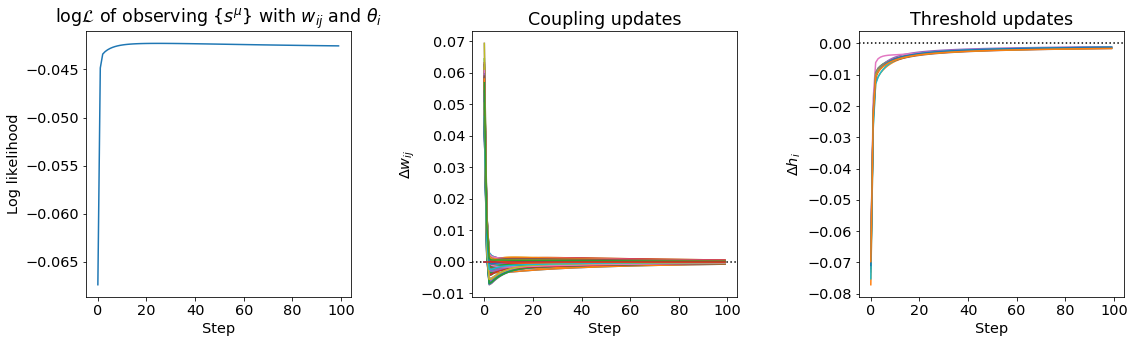

In [14]:
# the initial couplings and threshold are generated at the start, w and h, respectively
eta = 0.1
# L, w_updates, h_updates initiated above

tqdm_iter = tqdm(range(100))
for T in tqdm_iter:
    # calculate exact statistics
    _, _, p = calc_negE_Z_p(states, w, h)
    m = calc_mfr(states, p)
    S2 = calc_Esisj(states, p)

    # save likelihood of current couplings and thresholds
    L.append(loglikelihood(spikes.T, w, h))
    tqdm_iter.set_description("L={:.5f}".format(L[-1]))

    # terminate if change in likelihood is less than the threshold
    # with a patience of 10
    # if len(L) > 10 and abs((L[-10] - L[-1]) / L[-10]) < 0.0001: break

    # update parameters
    delw = eta * (S2_c - S2)
    w += delw
    # np.fill_diagonal(w, 0)
    delh = eta * (m_c - m)
    h += delh
    # save updates
    w_updates.append(np.ravel(delw))
    h_updates.append(delh)

f, axes = plt.subplots(1, 3, figsize=(16, 5))
ax = axes[0]
ax.plot(L)
ax.set_xlabel("Step")
ax.set_ylabel("Log likelihood")
ax.set_title(r"$\log\mathcal{L}$ of observing $\{s^\mu\}$ with $w_{ij}$ and $\theta_i$")

ax = axes[1]
ax.plot(w_updates)
ax.set_title("Coupling updates")
ax.set_xlabel("Step")
ax.set_ylabel(r"$\Delta w_{ij}$")
ax.hlines(0, ax.set_xlim()[0], ax.set_xlim()[1], ls=':')

ax = axes[2]
ax.plot(h_updates)
ax.set_title("Threshold updates")
ax.set_xlabel("Step")
ax.set_ylabel(r"$\Delta h_i$")
ax.hlines(0, ax.set_xlim()[0], ax.set_xlim()[1], ls=':')
f.tight_layout()
plt.show()

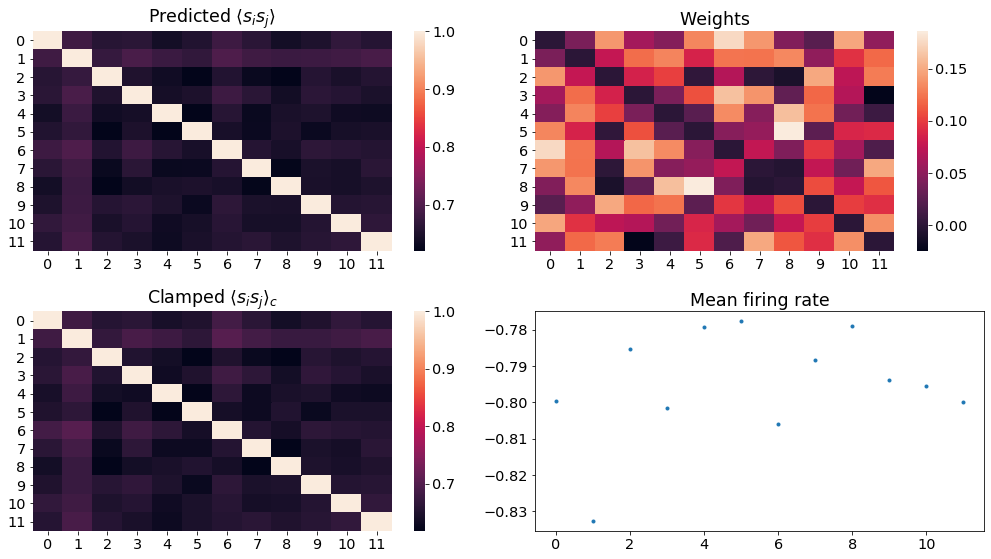

In [15]:
f, axes = plt.subplots(2, 2, figsize=(14, 8))
ax = axes[0, 0]
sns.heatmap(S2, ax=ax)
ax.set_title(r"Predicted $\langle s_is_j \rangle$")

ax = axes[0, 1]
sns.heatmap(w, ax=ax)
ax.set_title("Weights")

ax = axes[1, 0]
sns.heatmap(S2_c, ax=ax)
ax.set_title(r"Clamped $\langle s_is_j \rangle_c$")

ax = axes[1, 1]
ax.plot(m, '.')
ax.set_title("Mean firing rate")

f.tight_layout()
plt.show()

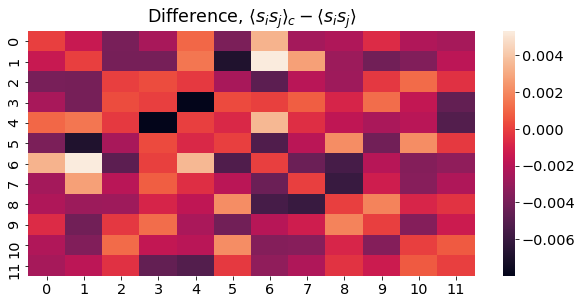

In [16]:
sns.heatmap(S2_c - S2)
plt.title(r"Difference, $\langle s_i s_j \rangle_c - \langle s_i s_j \rangle$")
plt.show()

From the plots above follows that the learned couplings and thresholds yield statistics which are near-identical.

### Generate new samples from learned couplings and thresholds

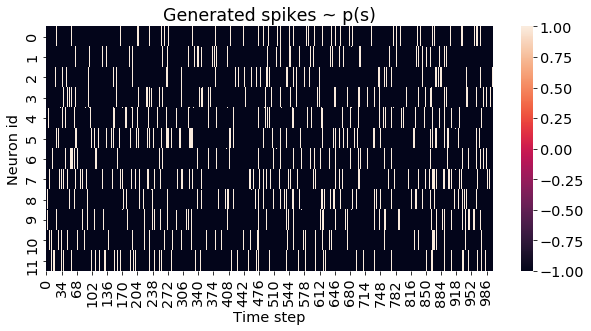

In [17]:
_, _, p = calc_negE_Z_p(states, w, h)
x = np.random.uniform(size=1000)
cp = np.cumsum(p)
gen_states = []
for xi in x:
    statenum = np.argmax((cp > xi))
    gen_states.append(states[statenum])
gen_states = np.array(gen_states)

f, ax = plt.subplots(1, 1)
sns.heatmap(gen_states.T, ax=ax)
ax.set_title("Generated spikes ~ p(s)")
ax.set_xlabel("Time step")
ax.set_ylabel("Neuron id")
plt.show()

# Part 2: approximate $\langle s_i s_j \rangle$ and $\langle s_i \rangle$ using Monte Carlo sampling

We want to sample from $p(s) = \frac{1}{Z} \exp\left( \frac{1}{2}\sum_{ij} w_{ij} s_is_j + \sum_i \theta_is_i\right)$. Calculating $Z$ becomes intractible, but $p^*(s) = \exp\left( \frac{1}{2}\sum_{ij} w_{ij} s_is_j + \sum_i \theta_is_i\right)$ is easily calculated for larger systems. 

As seen in Information Theory, Inference and Learning Algorithms from David MacKay, exercise 29.13, importance sampling is a way to approximate the expectation value of a funciton of a stochastic variable:  
$$\mathbb{E}[f(x)]_p = \int f(x)p(x)dx \approx \frac{Z_q}{Z_p}\cdot \frac{1}{N}\sum_i f(X_i) \tilde{w} (X_i)$$
In which $\tilde{w}(x) = \frac{\tilde{p}(x)}{\tilde{q}(x)}$, with $\tilde{p}(x) = Z_p p(x)$ and $\tilde{q}(x) = Z_q q(x)$.  

If we set $\tilde q(x) = q(x)$ (i.e. $Z_q = 1$), $Z_p$ is approximated by:  
$$Z_p \approx \frac{1}{N}\sum_i \tilde{w_i} 
= \frac{1}{N}\sum_i \frac{\tilde p(X_i)}{q(X_i)} $$

Combining these gives:  
$$
\begin{align}
\mathbb{E}[f(x)] &\approx \frac{1}{\frac{1}{N}\sum_i \frac{\tilde p(X_i)}{q(X_i)}}\frac{1}{N}\sum_i f(X_i) \frac{\tilde p(X_i)}{q(X_i)}\\
&= \frac{1}{\sum_i \tilde p(X_i)}\sum_i f(X_i) \tilde p(X_i)
\end{align}
$$

## Implement importance sampling Monte Carlo

In [18]:
def pstar(s, w, h):
    """Calculate p*(s) for state s with couplings w and thresholds h"""
    # S = np.matrix(s)
    # W = np.matrix(w)
    # negE = 0.5 * np.sum(S*W*S.T) + np.sum(h*s)
    # implementation below further improves 6500 ==> 10000 it/s
    negE = 0.5 * s@w@s.T + h@s
    return np.exp(negE)

def MC_stats(w, h, iterations=50000, verbose=True):
    norm_sum = 0
    s_sum = np.zeros(N)
    ss_sum = np.zeros((N,N))
    iterator = range(int(iterations))
    if verbose: iterator = tqdm(iterator)
    for T in iterator:
        # importance Monte Carlo sampling: generate random state s
        s = np.random.choice([-1, 1], size=N)
        # this uses a uniform q(s) = 1/2^N
        p_ = pstar(s, w, h)
        norm_sum += p_

        # evaluate f(X) for <s_i>
        s_sum += s * p_

        # evaluate f(X) for <s_i s_j>
        # matrix implementation speeds up from 2000it/s to 10.000it/s
        S = np.matrix(s)
        ss_sum += S.T @ S * p_
    return s_sum / norm_sum, ss_sum / norm_sum

# s_est, ss_est = MC_stats(w, h, iterations=1e5, verbose=False)

## Estimate the accuracy of the MC sampler
**Note: run the exact gradient ascent first to obtain the relevant couplings and thresholds!**  
Depending on your systems these runs can take a while. 

In [19]:
# calculate exact statistics
_, _, p = calc_negE_Z_p(states, w, h)
m = calc_mfr(states, p)
S2 = calc_Esisj(states, p)

In [20]:
s_errors_it_MC = []
ss_errors_it_MC = []
its = [1e3, 3e3, 1e4, 3e4, 1e5, 3e5, 1e6]

for run in tqdm(range(3), desc='Monte Carlo Sampling'):
    s_errors = np.zeros((len(its), N))
    ss_errors = np.zeros((len(its), N, N))

    for i, it in enumerate(its):
        it = int(it)
        s_est, ss_est = MC_stats(w, h, iterations=it, verbose=False)
        s_errors[i] = s_est - m
        ss_errors[i] = ss_est - S2
    
    s_errors_it_MC.append(s_errors)
    ss_errors_it_MC.append(ss_errors)

Monte Carlo Sampling: 100%|██████████| 3/3 [05:07<00:00, 102.42s/it]


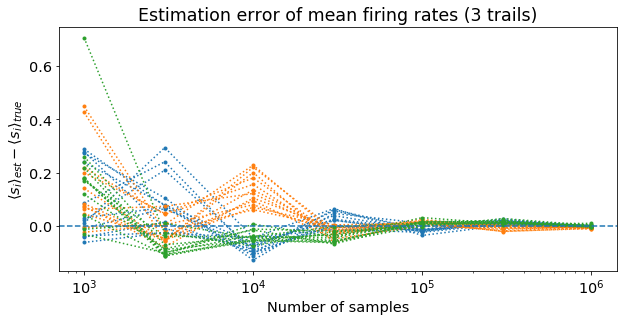

In [21]:
f, ax = plt.subplots(1, 1)
ax.set_xscale('log')
for i, s_errors in enumerate(s_errors_it_MC):
    ax.plot(its, s_errors, '.:', color='C%d'%i)
ax.axhline(0, ls='--')
ax.set_title("Estimation error of mean firing rates ({} trails)".format(len(s_errors_it_MC)))
ax.set_xlabel("Number of samples")
ax.set_ylabel(r"$\langle s_i\rangle_{est} - \langle s_i \rangle_{true}$")
plt.show()

With many samples (>100.000) the estimations become quite good. With fewer samples (<10.000) the estimations exhibit large errors. Sampling in Python can be done at about 10.000 samples/s, so these estimations take about 10 seconds or more. 

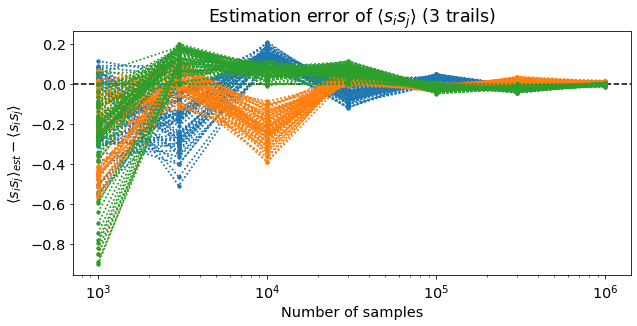

In [22]:
f, ax = plt.subplots(1, 1)
ax.set_xscale('log')
for i, ss_errors in enumerate(ss_errors_it_MC):
    ax.plot(its, [np.ravel(ss_errors[i]) for i in range(len(its))], '.:', color='C%d'%i)
ax.hlines(0, ax.set_xlim()[0], ax.set_xlim()[1], ls='--')
ax.set_title(r"Estimation error of $\langle s_i s_j \rangle$ ({} trails)".format(len(ss_errors_it_MC)))
ax.set_xlabel("Number of samples")
ax.set_ylabel(r"$\langle s_is_j\rangle_{est} - \langle s_i s_j \rangle$")
plt.show()

The same trend is visible for the mean spin products as for the mean firing rate estimation. 

### Distribution of estimation errors

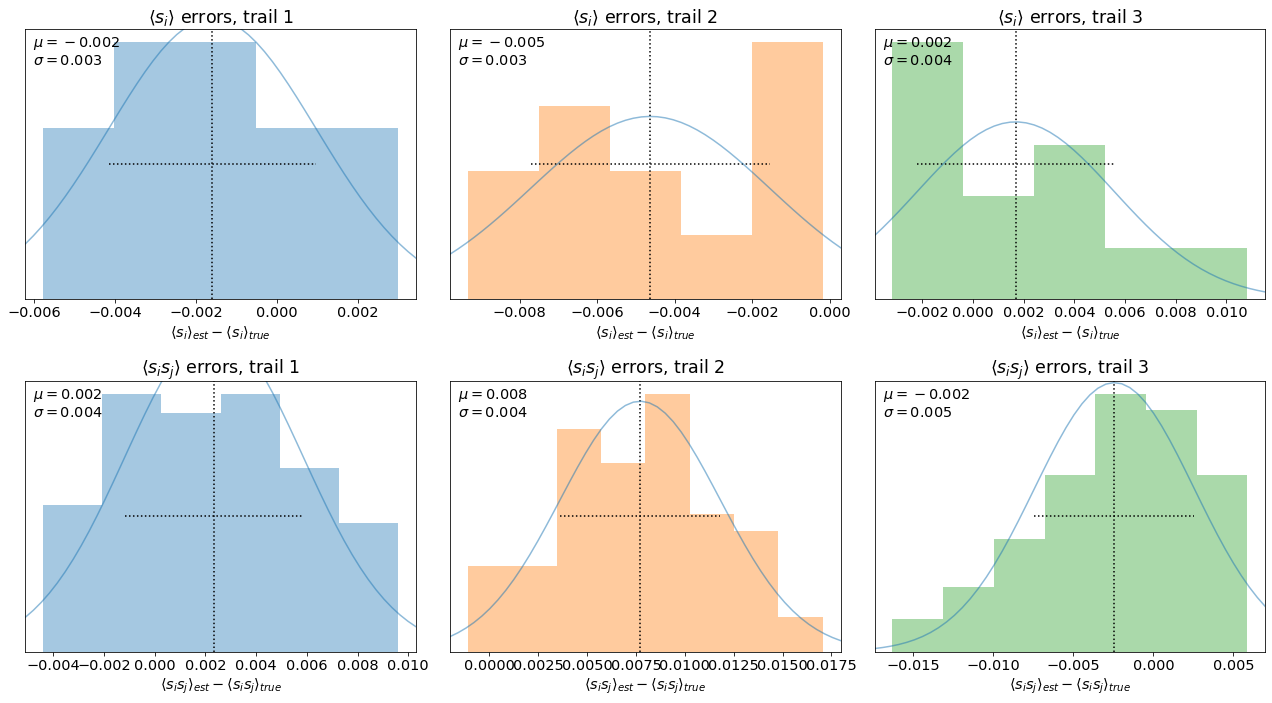

In [23]:
f, axes = plt.subplots(2, 3, figsize=(18, 10))
show_num = 3

for it, (s_errors, ss_errors) in enumerate(zip(s_errors_it_MC[:show_num], ss_errors_it_MC)):
    # show mean firing rate errors
    ax = axes[0, it]
    errs = s_errors[-1]
    sns.distplot( errs, ax=ax, kde=False, norm_hist=True, bins=5, color='C%d'%it )
    mean, std = np.mean(errs), np.std(errs)
    ax.axvline(mean, ls=':', color='k')
    ax.hlines(ax.set_ylim()[1]/2, mean - std, mean+std, ls=':')
    
    ax.set_title(r"$\langle s_i \rangle$ errors, trail {}".format(it+1))
    ax.set_xlabel(r"$\langle s_i \rangle_{est} - \langle s_i \rangle_{true}$")
    ax.text(.02, .98, '$\mu = {:.3f}$\n$\sigma = {:.3f}$'.format(mean, std),
            horizontalalignment='left',
            verticalalignment='top',
            transform=ax.transAxes)
    xr = np.linspace(*ax.set_xlim())
    ax.plot( xr, (2*np.pi*std*std)**(-0.5) * np.exp(-(xr - mean)**2 / (2 * std * std)), alpha=0.5 )
    
    # show mean spin product errors
    ax = axes[1, it]
    # discard errors on diagonal, as <s_i s_j> is always correct for i=j
    # and only select errors of 'upper triangle' to prevent selecting elements twice (swapping i and j)
    idx = [(i, j) for i in range(N) for j in range(i)]
    errs = [ss_errors[-1][i, j] for (i,j) in idx]

    sns.distplot( errs, ax=ax, kde=False, norm_hist=True, color='C%d'%it)
    mean, std = np.mean(errs), np.std(errs)
    ax.axvline(mean, ls=':', color='k')
    ax.hlines(ax.set_ylim()[1]/2, mean - std, mean+std, ls=':')

    ax.set_title(r"$\langle s_i s_j \rangle$ errors, trail {}".format(it+1))
    ax.set_xlabel(r"$\langle s_i s_j\rangle_{est} - \langle s_i s_j \rangle_{true}$")
    ax.text(.02, .98, '$\mu = {:.3f}$\n$\sigma = {:.3f}$'.format(mean, std),
            horizontalalignment='left',
            verticalalignment='top',
            transform=ax.transAxes)
    xr = np.linspace(*ax.set_xlim())
    ax.plot( xr, (2*np.pi*std*std)**(-0.5) * np.exp(-(xr - mean)**2 / (2 * std * std)), alpha=0.5 )

for ax in np.ravel(axes):
    ax.set_yticks([])

f.tight_layout()
plt.show()

## Implement Metropolis-Hasting Monte Carlo Markov Chain

If we have $p(s)=\frac{1}{Z}\exp(-E(s))$, we can employ Metropolis-Hasting if we can evaluate $E(s)$, which we can.

Using the samples obtained from the Metropolis-Hasting MCMC sampler, the relevant quantities are calculated as:
$$
\mathbb{E}[f(x)] \approx \frac{1}{N} \sum_i f(X_i)
$$  

For more information about this sampler, see one of the following: 
- Information Theory, Inference and Learning Algorithms from David MacKay
- github/[TODO]

In [24]:
def findE(s, w, h):
    """Calculate E(s) for state s with couplings w and thresholds h"""
    # note: need matrix multiplication, so use '@' instead of '*'
    return -(0.5 * s@w@s.T + h@s)

def MHMC_sampler(w, h, iterations=50000, burn=0.1, flip=1, verbose=True):
    samples = []
    accepted_direct = 0
    accepted_unif = 0
    energies = []
    # generate random starting state
    s = np.random.choice([-1, 1], size=N)
    E = findE(s, w, h)
    # calculate burn if float
    if isinstance(burn, float): burn = int(iterations*burn)

    iterator = range(iterations)
    if verbose: iterator = tqdm(iterator)
    for i in iterator:
        samples.append(s)
        
        # Stappen maken doe je samen
        snew = s.copy()
        # if flip is >= 1, it codes the number of states to flip
        if flip >= 1:
            flip = int(flip)
            idx = np.random.choice(np.arange(len(s)), replace=False, size=flip)
            snew[idx] *= -1
        else:
            # flip is percentage of spins to flip
            snew *= np.random.choice([-1, 1], p=[flip, 1-flip], size=N) # takes ~30 microseconds
        # randomly swap 5% of the spins (number of spins swapped varies on a trail to trail basis)
        
        Enew = findE(snew, w, h)
        
        if (Enew < E): # always accept
            s = snew
            E = Enew
            accepted_direct += 1
        elif (np.exp(E-Enew) > np.random.uniform()):
            # higher 'energy', generate alpha = np.exp(-Enew)/np.exp(-E)
            s = snew
            E = Enew
            accepted_unif += 1
        # not accepted, stay at current state
        energies.append(E)
    
    if verbose:
        print("Accepted {:.1%} of proposed samples directly, {:.1%} exp > unif, {:.1%} in total".format(
            accepted_direct/len(samples), accepted_unif/len(samples), (accepted_direct+accepted_unif)/len(samples)))
        print("Burn {} samples".format(burn))
    
    acceptance_ratio = (accepted_direct+accepted_unif)/len(samples)
    if burn:
        samples = np.array(samples[burn:])
    else:
        samples = np.array(samples)
    
    return samples, acceptance_ratio

def MHMC_stats(w, h, iterations, flip=1, verbose=True):
    samples, acceptance_ratio = MHMC_sampler(w, h, iterations=int(iterations), flip=flip, verbose=verbose)

    if verbose: print("Calculating <s_i>...")
    s_est = np.mean(samples, axis=0)
    # ss_sum = np.zeros((N,N))
    # for s in samples:
    #     S = np.matrix(s)
    #     ss_sum += S.T @ S
    # ss_sum / len(samples)
    # below is approx 10x faster
    if verbose: print("Calculating <s_i s_j>...")
    ss_est = samples.T @ samples / len(samples)

    return s_est, ss_est, acceptance_ratio

# samples = MHMC_samples(w, h, iterations=int(1e6), burn=0)
# MHMC_stats(w, h, iterations=int(1e6))

## Estimate the accuracy of the Metropolis-Hasting MCMC sampler
**Note: run the exact gradient ascent first to obtain the exact statistics!**

In [25]:
s_errors_it_MHMCMC = []
ss_errors_it_MHMCMC = []
its = [1e3, 3e3, 1e4, 3e4, 1e5, 3e5, 1e6]

for run in tqdm(range(3), desc='MH MCMC Sampling'):
    s_errors = np.zeros((len(its), N))
    ss_errors = np.zeros((len(its), N, N))

    for i, it in enumerate(its):
        it = int(it)
        s_est, ss_est = calculate_statistics(w, h, N, num_samples=it, verbose=False,
                                             cpp_sampler=use_cpp_sampler, num_threads=num_cpp_threads)
        s_errors[i] = s_est - m
        ss_errors[i] = ss_est - S2
    
    s_errors_it_MHMCMC.append(s_errors)
    ss_errors_it_MHMCMC.append(ss_errors)

MH MCMC Sampling: 100%|██████████| 3/3 [00:00<00:00,  5.36it/s]


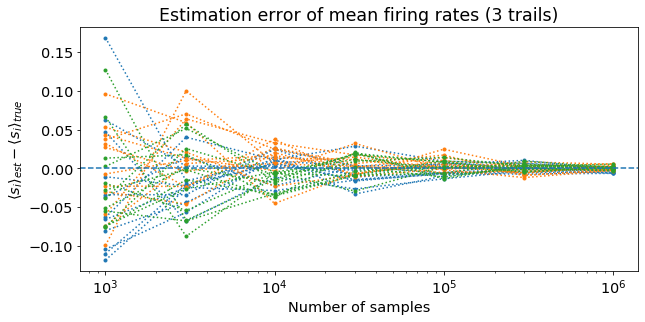

In [26]:
f, ax = plt.subplots(1, 1)
ax.set_xscale('log')
for i, s_errors in enumerate(s_errors_it_MHMCMC):
    ax.plot(its, s_errors, '.:', color='C%d'%i)
ax.axhline(0, ls='--')
ax.set_title("Estimation error of mean firing rates ({} trails)".format(len(s_errors_it_MHMCMC)))
ax.set_xlabel("Number of samples")
ax.set_ylabel(r"$\langle s_i\rangle_{est} - \langle s_i \rangle_{true}$")
plt.show()

The estimation error is lower compared to the vanilla Monte Carlo sampler, while even improving in sampling speed due to some performance optimizations. Using the C++ sampler speeds up sampling by an additional factor, about 10x faster. 

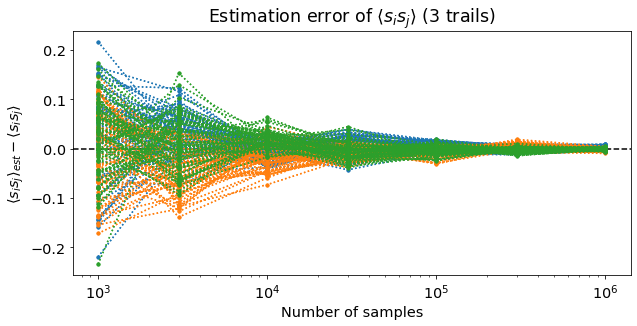

In [27]:
f, ax = plt.subplots(1, 1)
ax.set_xscale('log')
for it, ss_errors in enumerate(ss_errors_it_MHMCMC):
    ax.plot(its, [np.ravel(ss_errors[i]) for i in range(len(its))], '.:', color='C%d'%it)
ax.hlines(0, ax.set_xlim()[0], ax.set_xlim()[1], ls='--')
ax.set_title(r"Estimation error of $\langle s_i s_j \rangle$ ({} trails)".format(len(ss_errors_it_MHMCMC)))
ax.set_xlabel("Number of samples")
ax.set_ylabel(r"$\langle s_is_j\rangle_{est} - \langle s_i s_j \rangle$")
plt.show()

The same trend is visible as for the mean firing rate estimation. 

## Compare accuracy of MC approximation with MH MCMC approximation

In [28]:
# ss_errors_it_(HMMC)MC contains a list of trails, with a list of the number of iterations, with the list of errors
# want a list of mean errors (bias), per number of iterations
# and the std of the errors, per number of iterations
s_errors_MC = s_errors_it_MC.copy()
ss_errors_MC = ss_errors_it_MC.copy()
s_errors_MHMCMC = s_errors_it_MHMCMC.copy()
ss_errors_MHMCMC = ss_errors_it_MHMCMC.copy()

# swap axes 0 and 1
s_errors_MC = np.swapaxes(s_errors_MC, 0, 1)
ss_errors_MC = np.swapaxes(ss_errors_MC, 0, 1)
s_errors_MHMCMC = np.swapaxes(s_errors_MHMCMC, 0, 1)
ss_errors_MHMCMC = np.swapaxes(ss_errors_MHMCMC, 0, 1)

### Mean firing rate errors

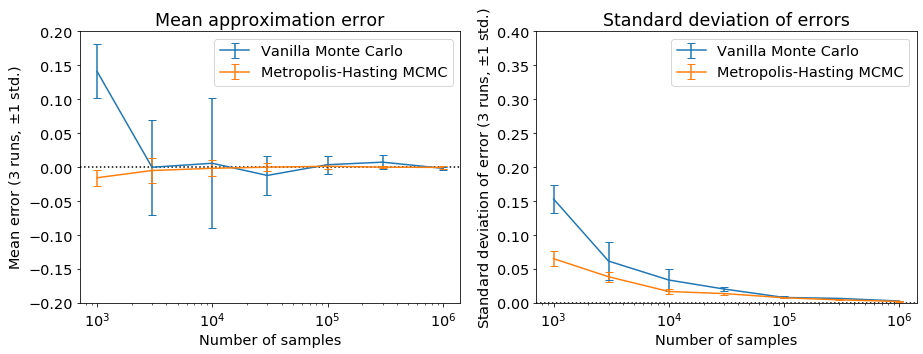

In [29]:
s_mean_MC = np.mean(s_errors_MC, axis=2)
s_mean_MHMCMC = np.mean(s_errors_MHMCMC, axis=2)

f, axes = plt.subplots(1, 2, figsize=(15, 5))
ax = axes[0]
ax.set_xscale('log')
ax.errorbar(x=its, y=np.mean(s_mean_MC, axis=1), yerr=np.std(s_mean_MC, axis=1), 
            capsize=4, label='Vanilla Monte Carlo')
ax.errorbar(x=its, y=np.mean(s_mean_MHMCMC, axis=1), yerr=np.std(s_mean_MHMCMC, axis=1), 
            capsize=4, label='Metropolis-Hasting MCMC')
ax.set_xlabel("Number of samples")
ax.set_ylabel(r"Mean error ({} runs, $\pm 1$ std.)".format(s_errors_MC.shape[1]))
ax.set_title("Mean approximation error")
ax.set_ylim(-0.2, 0.2)
ax.hlines(0, ax.set_xlim()[0], ax.set_xlim()[1], ls=':')
ax.legend()

# same for std
s_std_MC = np.std(s_errors_MC, axis=2)
s_std_MHMCMC = np.std(s_errors_MHMCMC, axis=2)

ax = axes[1]
ax.set_xscale('log')
ax.errorbar(x=its, y=np.mean(s_std_MC, axis=1), yerr=np.std(s_std_MC, axis=1), 
            capsize=4, label='Vanilla Monte Carlo')
ax.errorbar(x=its, y=np.mean(s_std_MHMCMC, axis=1), yerr=np.std(s_std_MHMCMC, axis=1), 
            capsize=4, label='Metropolis-Hasting MCMC')
ax.set_xlabel("Number of samples")
ax.set_ylabel(r"Standard deviation of error ({} runs, $\pm 1$ std.)".format(s_errors_MC.shape[1]))
ax.set_title("Standard deviation of errors")
ax.set_ylim(0, 0.4)
ax.hlines(0, ax.set_xlim()[0], ax.set_xlim()[1], ls=':')
ax.legend()

f.savefig("bias_std_approximations_mfr")
plt.show()

### Mean spin product errors

In [30]:
sh = ss_errors_MC.shape
ss_errors_MC = ss_errors_MC.reshape(sh[0], sh[1], sh[2]*sh[3])
ss_errors_MHMCMC = ss_errors_MHMCMC.reshape(sh[0], sh[1], sh[2]*sh[3])

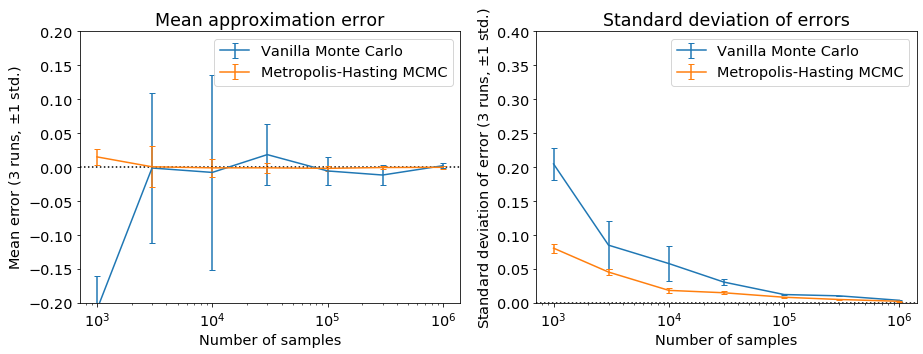

In [31]:
ss_mean_MC = np.mean(ss_errors_MC, axis=2)
ss_mean_MHMCMC = np.mean(ss_errors_MHMCMC, axis=2)

f, axes = plt.subplots(1, 2, figsize=(15, 5))
ax = axes[0]
ax.set_xscale('log')
ax.errorbar(x=its, y=np.mean(ss_mean_MC, axis=1), yerr=np.std(ss_mean_MC, axis=1), 
            capsize=3, label='Vanilla Monte Carlo')
ax.errorbar(x=its, y=np.mean(ss_mean_MHMCMC, axis=1), yerr=np.std(ss_mean_MHMCMC, axis=1), 
            capsize=3, label='Metropolis-Hasting MCMC')
ax.set_xlabel("Number of samples")
ax.set_ylabel(r"Mean error ({} runs, $\pm 1$ std.)".format(s_errors_MC.shape[1]))
ax.set_title("Mean approximation error")
ax.set_ylim(-0.2, 0.2)
ax.hlines(0, ax.set_xlim()[0], ax.set_xlim()[1], ls=':')
ax.legend()

# same for std
ss_std_MC = np.std(ss_errors_MC, axis=2)
ss_std_MHMCMC = np.std(ss_errors_MHMCMC, axis=2)

ax = axes[1]
ax.set_xscale('log')
ax.errorbar(x=its, y=np.mean(ss_std_MC, axis=1), yerr=np.std(ss_std_MC, axis=1), 
            capsize=3, label='Vanilla Monte Carlo')
ax.errorbar(x=its, y=np.mean(ss_std_MHMCMC, axis=1), yerr=np.std(ss_std_MHMCMC, axis=1), 
            capsize=3, label='Metropolis-Hasting MCMC')
ax.set_xlabel("Number of samples")
ax.set_ylabel(r"Standard deviation of error ({} runs, $\pm 1$ std.)".format(ss_errors_MC.shape[1]))
ax.set_title("Standard deviation of errors")
ax.set_ylim(0, 0.4)
ax.hlines(0, ax.set_xlim()[0], ax.set_xlim()[1], ls=':')
ax.legend()

f.savefig("bias_std_approximations_sisj")
plt.show()

**Result**: The estimations for the mean firing rates and mean spin products are much better when using the Metropolis-Hasting MCMC sampler. Also, sampling performance (number of samples per second) is better, also when using the Python sampler (not shown). 

## Check number of flips
The Metropolis-Hasting MCMC sampler uses a proposal distribution with a certain number of spins flipped from the current state. This part checks what the optimal number of spin flips is. This uses the Python sampler. 

In [32]:
s_errors_flips_MHMCMC = []
ss_errors_flips_MHMCMC = []

for run in tqdm(range(5), desc='MH MCMC Sampling'):
    flips = list(range(1, 5+1))
    s_errors = np.zeros((len(flips), N))
    ss_errors = np.zeros((len(flips), N, N))

    for i, flip in enumerate(flips):
        s_est, ss_est, acceptance_ratio = MHMC_stats(w, h, iterations=1e5, flip=flip, verbose=False)
        s_errors[i] = s_est - m
        ss_errors[i] = ss_est - S2
    
    s_errors_flips_MHMCMC.append(s_errors)
    ss_errors_flips_MHMCMC.append(ss_errors)

MH MCMC Sampling: 100%|██████████| 5/5 [01:22<00:00, 16.60s/it]


In [33]:
# ss_errors_flips_HMMCMC contains a list of trails, with a list of the number of flips, with the list of errors
s_errors_MHMCMC = s_errors_flips_MHMCMC.copy()
ss_errors_MHMCMC = ss_errors_flips_MHMCMC.copy()

# swap axes 0 and 1
s_errors_MHMCMC = np.swapaxes(s_errors_MHMCMC, 0, 1)
ss_errors_MHMCMC = np.swapaxes(ss_errors_MHMCMC, 0, 1)

In [34]:
# discard errors on diagonal, as <s_i s_j> is always correct for i=j
# and only select errors of 'upper triangle' to prevent selecting elements twice (swapping i and j)
idx = [(i, j) for i in range(N) for j in range(i)]
num_flips, num_its, N, N = ss_errors_MHMCMC.shape
ss_errors_temp = np.zeros(shape=( num_flips, num_its, int((N*N-N)/2)  ))
for k in range(num_flips):
    for l in range(num_its):
        ss_errors_temp[k, l] = [ss_errors_MHMCMC[k, l, i, j] for (i,j) in idx]
ss_errors_MHMCMC = ss_errors_temp.copy()

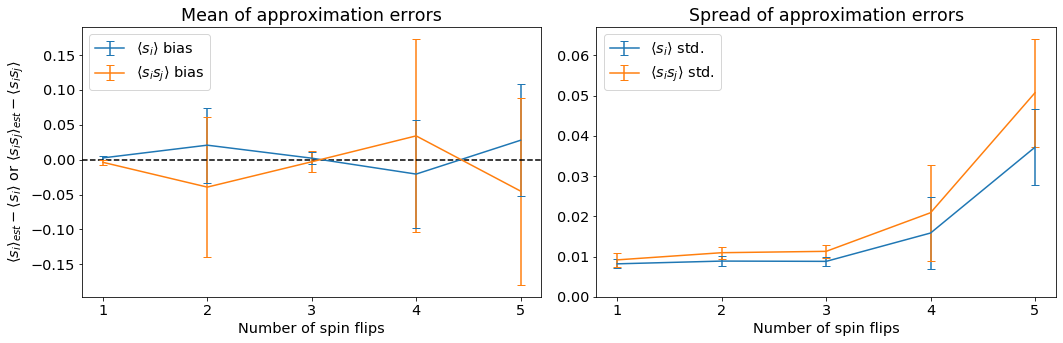

In [35]:
f, axes = plt.subplots(1, 2, figsize=(15, 5))
ax = axes[0]

s_mean_MHMCMC = np.mean(s_errors_MHMCMC, axis=2)
ss_mean_MHMCMC = np.mean(ss_errors_MHMCMC, axis=2)

ax.errorbar(x=flips, y=np.mean(s_mean_MHMCMC, axis=1), yerr=np.std(s_mean_MHMCMC, axis=1), 
            capsize=4, label=r'$\langle s_i \rangle$ bias')
ax.errorbar(x=flips, y=np.mean(ss_mean_MHMCMC, axis=1), yerr=np.std(ss_mean_MHMCMC, axis=1), 
            capsize=4, label=r'$\langle s_i s_j \rangle$ bias')
ax.set_xticks(flips)
ax.hlines(0, ax.set_xlim()[0], ax.set_xlim()[1], ls='--')
ax.set_title("Mean of approximation errors")
ax.set_xlabel("Number of spin flips")
ax.set_ylabel(r"$\langle s_i\rangle_{est} - \langle s_i \rangle$ or $\langle s_i s_j\rangle_{est} - \langle s_i s_j\rangle$")
ax.legend()

# same for std
s_std_MHMCMC = np.std(s_errors_MHMCMC, axis=2)
ss_std_MHMCMC = np.std(ss_errors_MHMCMC, axis=2)
ax = axes[1]
ax.errorbar(x=flips, y=np.mean(s_std_MHMCMC, axis=1), yerr=np.std(s_std_MHMCMC, axis=1), 
            capsize=4, label=r'$\langle s_i \rangle$ std.')
ax.errorbar(x=flips, y=np.mean(ss_std_MHMCMC, axis=1), yerr=np.std(ss_std_MHMCMC, axis=1), 
            capsize=4, label=r'$\langle s_i s_j \rangle$ std.')
ax.set_xticks(flips)
ax.set_ylim(0)
ax.set_title(r"Spread of approximation errors")
ax.set_xlabel("Number of spin flips")
ax.set_ylabel(r"")
ax.legend()

f.tight_layout()
plt.show()

# Part 3: Boltmann Machine learning with Hasting-Metropolis MCMC sampling for Salamander retina

## Retrieve data
The Salamander retina data is obtained from https://research-explorer.app.ist.ac.at/record/parent-system/datarep/61.

_"(2) a zipped .txt file containing the same data represented as an array with dimensions “number of neurons” x “number of samples”, where the number of samples is equal to the product of the number of repeats and timebins within a repeat. The time dimension is divided into 20 ms time windows, and the array is binary indicating whether a given cell elicited at least one spike in a given time window during a particular repeat."_

In [36]:
from urllib.request import urlretrieve
import os
def download(url, file):
    if not os.path.isfile(file):
        urlretrieve(url, file)

file_url = "https://research-explorer.app.ist.ac.at/download/5562/5623/IST-2017-61-v1%2B2_bint_fishmovie32_100.zip"
download(file_url, "salamander.zip")

In [37]:
!unzip -q salamander.zip
!rm salamander.zip

replace bint.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [38]:
print("Loading Salamander retina data...")
data = np.loadtxt("bint.txt", dtype=int)
print("data shape: ", data.shape)
print("Changing 0 to -1...")
data[data == 0] = -1

Loading Salamander retina data...
data shape:  (160, 283041)
Changing 0 to -1...


This has the same shape as our toy data, but then ~10 times as many neurons and ~1000 times as many measurements. The block above also changes the representation for a neuron at rest from 0 to -1, for compatibility with the formulae of the Ising Model / Boltzmann Machine Learning rules.

## Get playing field

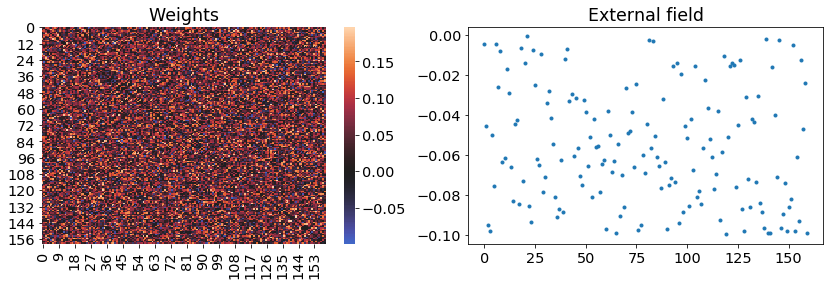

In [39]:
N = 160
# generate random couplings and biases
w = np.random.uniform(low=-0.1, high=0.2, size=(N,N))
w = (w + w.T) / 2 # symmetrize couplings
np.fill_diagonal(w, 0) # set coupling to self to zero
h = np.random.uniform(low=-0.1, high=0, size=N) # biases

f, axes = plt.subplots(1, 2, figsize=(14,4))
ax = axes[0]
sns.heatmap(w, center=0, ax=ax)
ax.set_title("Weights")

ax = axes[1]
ax.plot(np.arange(len(h)), h, '.')
ax.set_title("External field")
plt.show()

## Calculate clamped statistics

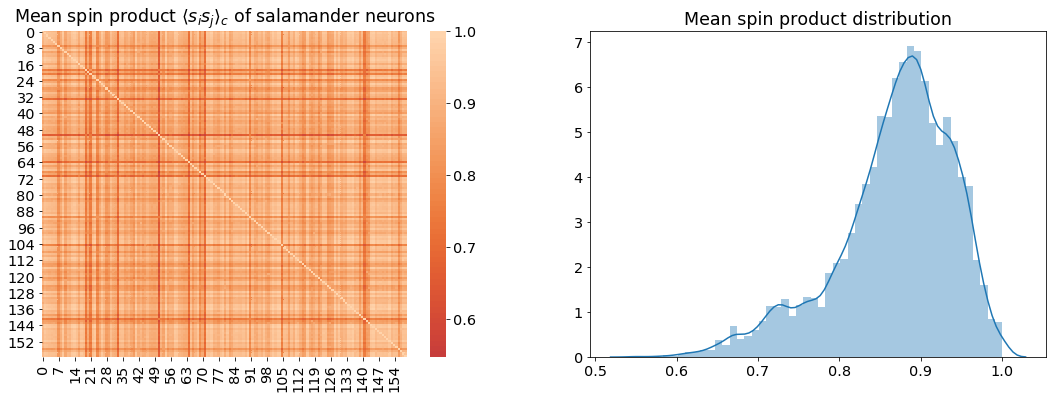

Clamped mean firing rates: 


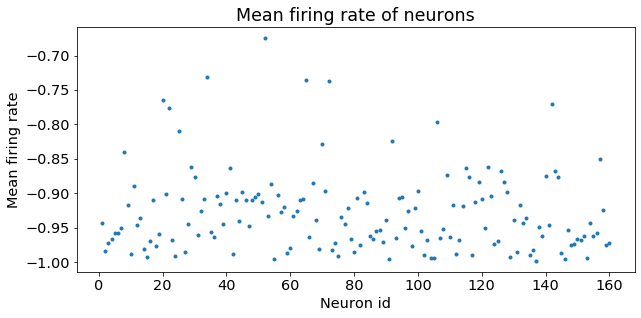

In [40]:
N, P = data.shape

# calculate clamped mean firing rate
m_c = 1/P * np.sum(data, axis=1)

# calculate clamped <si sj>
S2_c = np.zeros((N, N))
X_c = np.zeros((N, N))
for i in range(N):
    for j in range(i, N): # only calculate half, for correlations are symmetric
        if i == j: pass
        # calculate sum of s_i s_j of samples
        S2_c[i, j] = np.sum(data[i,:] * data[j,:]) / P
        X_c[i, j] = S2_c[i, j] - m_c[i] * m_c[j]
        # copy to symmetric part
        S2_c[j, i] = S2_c[i, j] # can also ommit this part and change
        X_c[j, i] = X_c[i, j]
        # range(i, N) to range(0, N) and still obtain the same result

f, axes = plt.subplots(1, 2, figsize=(18, 6))
ax = axes[0]
sns.heatmap(S2_c, center=0, ax=ax)
ax.set_title(r"Mean spin product $\langle s_i s_j \rangle_c$ of salamander neurons")

ax = axes[1]
sns.distplot(np.ravel(S2_c), ax=ax)
ax.set_title("Mean spin product distribution")

plt.show()

print("Clamped mean firing rates: ")
f, ax = plt.subplots(1, 1)
ax.plot(np.arange(len(m_c))+1, m_c, '.'); ax.set_xlabel("Neuron id")
ax.set_ylabel("Mean firing rate"); ax.set_title("Mean firing rate of neurons")
plt.show()

## Perform Boltzmann Machine learning
The Boltzmann Machine Learning rules use gradient ascent to maximize the likelihood of observing the neuron data. The algorithm below uses a learning rate decay scheme, to speed of convergence initially and ensure convergence at the end. 

In [41]:
w_updates, h_updates = [], []
w_list, h_list = [], []

Boltzmann learning, eta = 0.1: 100%|██████████| 100/100 [02:56<00:00,  1.77s/it]


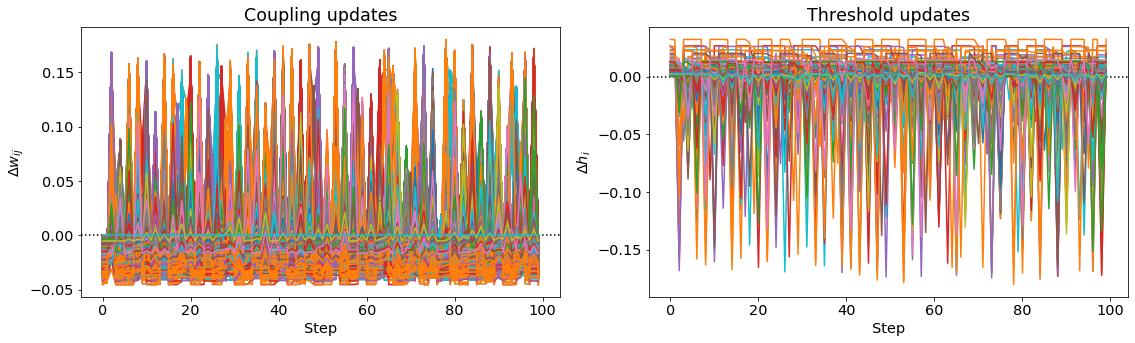

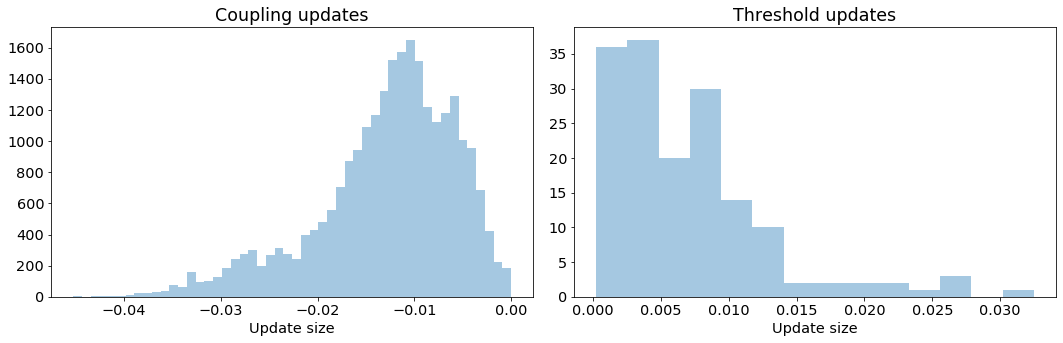

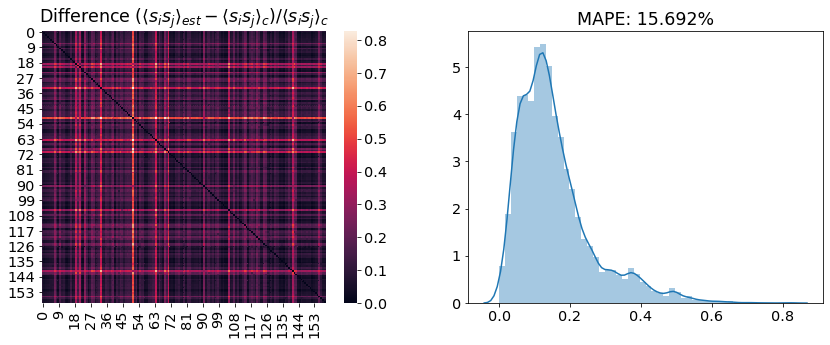

Boltzmann learning, eta = 0.01: 100%|██████████| 100/100 [03:01<00:00,  1.82s/it]


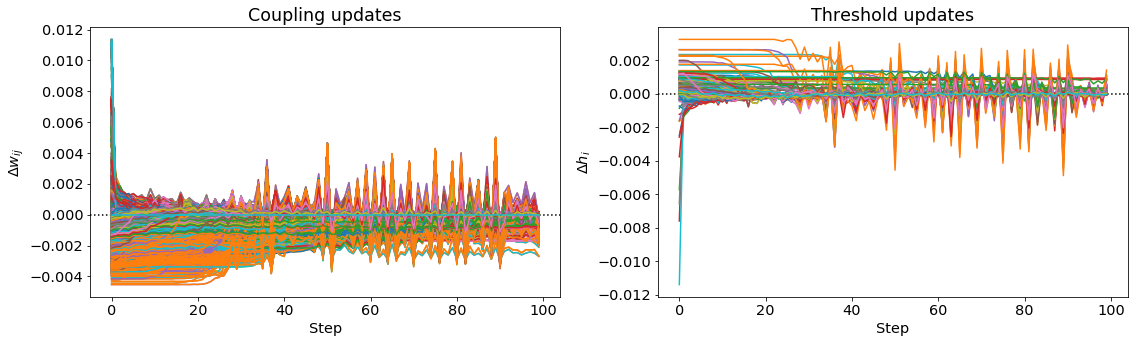

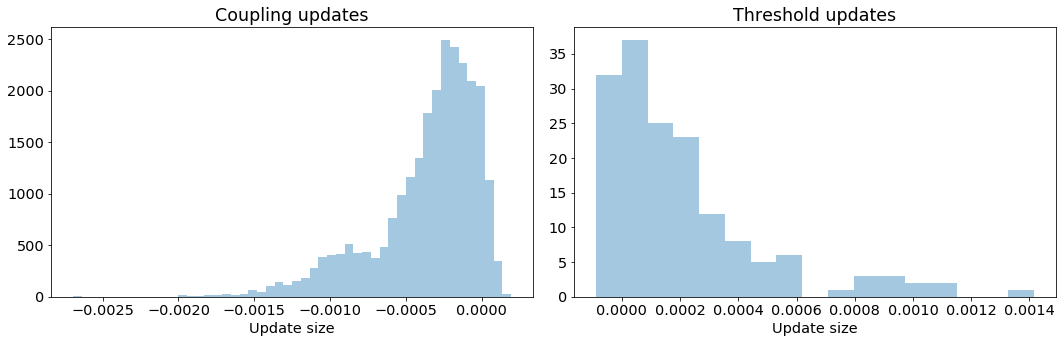

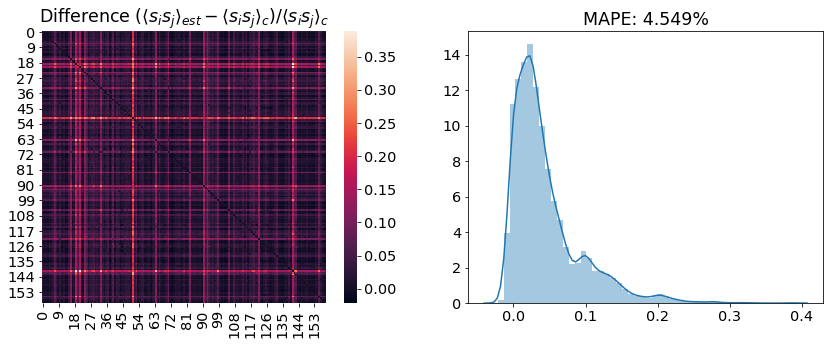

Boltzmann learning, eta = 0.001: 100%|██████████| 100/100 [02:58<00:00,  1.79s/it]


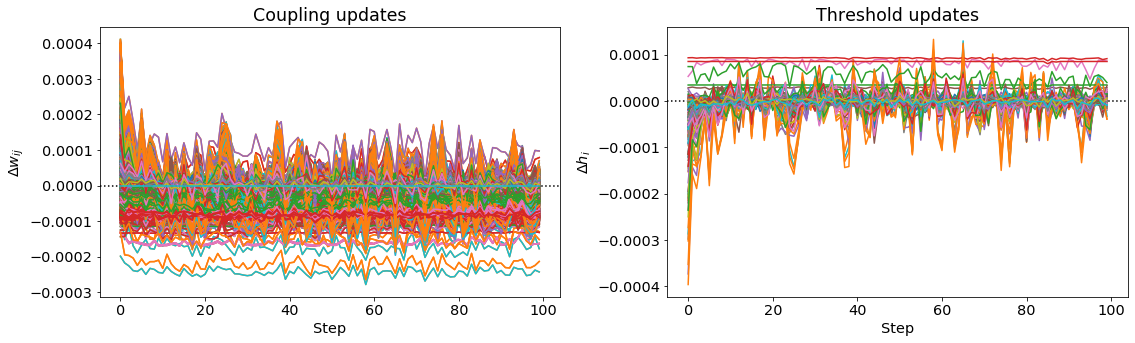

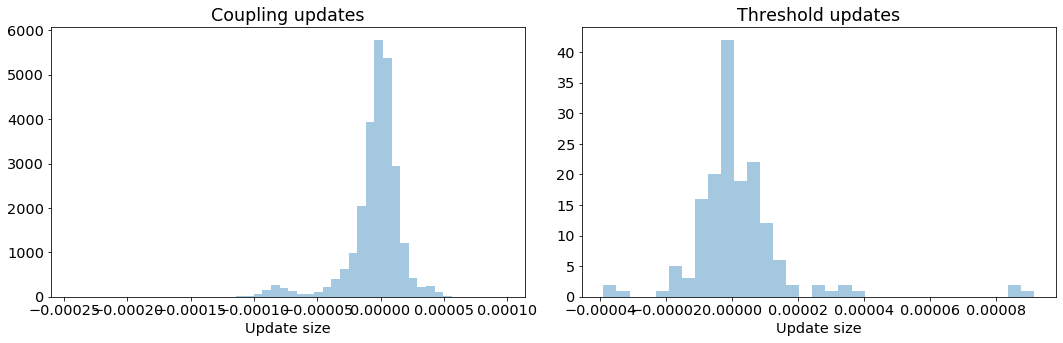

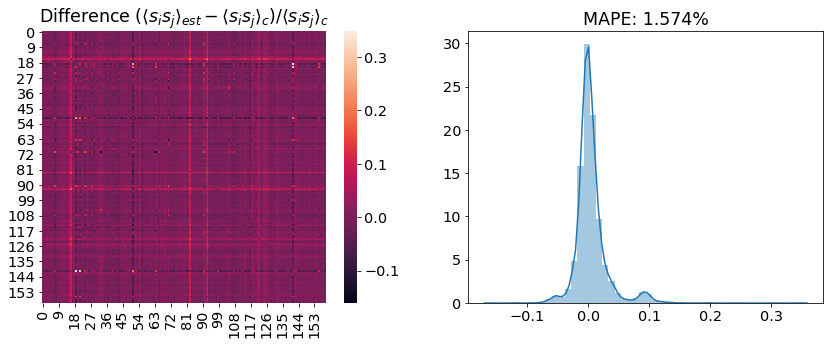

In [42]:
num_samples_per_step = int(1e6)
num_steps_per_part = 100 # have three parts with decaying learning rate

for eta in [0.1, 0.01, 0.001]:
    for T in tqdm(range(num_steps_per_part), desc="Boltzmann learning, eta = {}".format(eta)):
        # estimate statistics
        m_est, S2_est = calculate_statistics_ram_friendlier(w, h, N, num_samples=num_samples_per_step, 
                                             cpp_sampler=use_cpp_sampler, num_threads=num_cpp_threads)

        # update parameters
        delw = eta * (S2_c - S2_est)
        w += delw
        delh = eta * (m_c - m_est)
        h += delh

        # save updates
        w_updates.append(np.ravel(delw))
        h_updates.append(delh)
    
    f, axes = plt.subplots(1, 2, figsize=(16, 5))
    ax = axes[0]
    ax.plot(w_updates[-num_steps_per_part:])
    ax.set_title("Coupling updates")
    ax.set_xlabel("Step")
    ax.set_ylabel(r"$\Delta w_{ij}$")
    ax.hlines(0, ax.set_xlim()[0], ax.set_xlim()[1], ls=':')

    ax = axes[1]
    ax.plot(h_updates[-num_steps_per_part:])
    ax.set_title("Threshold updates")
    ax.set_xlabel("Step")
    ax.set_ylabel(r"$\Delta h_i$")
    ax.hlines(0, ax.set_xlim()[0], ax.set_xlim()[1], ls=':')
    f.tight_layout()
    plt.show()

    f, axes = plt.subplots(1, 2, figsize=(15, 5))
    ax = axes[0]
    sns.distplot(np.ravel(delw), ax=ax, kde=False)
    ax.set_title("Coupling updates")
    ax.set_xlabel("Update size")

    ax = axes[1]
    sns.distplot(delh, ax=ax, kde=False)
    ax.set_title("Threshold updates")
    ax.set_xlabel("Update size")
    f.tight_layout()
    plt.show()

    f, axes = plt.subplots(1, 2, figsize=(14, 5))
    ax = axes[0]
    S2_diff = (S2_est - S2_c) / S2_c
    sns.heatmap(S2_diff, ax=ax)
    ax.set_title(r"Difference $(\langle s_i s_j \rangle_{est} - \langle s_i s_j \rangle_c) / \langle s_i s_j \rangle_c$")

    ax = axes[1]
    sns.distplot(np.ravel(S2_diff), ax=ax)
    ax.set_title("MAPE: {:.3%}".format(np.mean(np.abs(S2_diff))))

    plt.show()

In [43]:
# save learning couplings and thresholds
np.save("Salamander_w.npy", w)
np.save("Salamander_h.npy", h)

## Employ Boltzmann Machine to make predictions
The blocks below will reproducte Figure 2a of the paper "Weak pairwise correlations imply strongly correlated network states in a neural population" by Elad Schneidman, Michael J. Berry II, Ronen Segev & William Bialek, https://www.nature.com/articles/nature04701. 

In [44]:
# load w and h from previous block
w = np.load("Salamander_w.npy")
h = np.load("Salamander_h.npy")
N = len(h)

In [45]:
neuron_ids = np.arange(9, 18+1)
# neuron_ids = np.random.choice(np.arange(160), replace=False, size=10)

In [48]:
# store results
res = {key: 0 for key in range(2**10)}
iterations = 10 # increase for better predictions
samples_per_iteration = int(1e6)

for it in tqdm(range(iterations)):
    # Sample
    if use_cpp_sampler:
        # load C++ sampler
        spec = importlib.util.spec_from_file_location("Worker", os.environ['COMPILED_WORKER_PATH'])
        cpp = importlib.util.module_from_spec(spec)
        spec.loader.exec_module(cpp)
        
        # create worker object with relevant couplings, external field and number of neurons
        worker = cpp.Worker(w, h, N, samples_per_iteration, num_cpp_threads) # total iterations, threads
        worker.sample()
        samples_list = worker.get_samples_list()
    
        # combine list of samples
        samples = np.array(samples_list, dtype=np.int8)
        sh = samples.shape
        samples = samples.reshape(sh[0]*sh[1], sh[2])
    else:
        samples, acc_ratio = MHMC_sampler(w, h, iterations=int(samples_per_iteration), verbose=False)
    
    # get firing patern rates of sampler
    mc_patterns = samples[:, neuron_ids]
    unique_mc_patterns, mc_counts = np.unique(mc_patterns, axis=0, return_counts=True)
    # convert to nums to save easier
    unique_mc_nums = encode(unique_mc_patterns, N=len(neuron_ids))
    # save to dict
    for k, v in zip(unique_mc_nums, mc_counts):
        res[k] += v

100%|██████████| 10/10 [00:55<00:00,  5.53s/it]


In [49]:
total_num_patterns = np.sum(list(res.values()))
print("Have {} ({:.1e}) patterns in total".format(total_num_patterns, total_num_patterns))

Have 9500000 (9.5e+06) patterns in total


In [50]:
# convert counts from above to rates 
# and convert state numbers to states (numbers are states when converted to binary rep.)
unique_mc_nums, mc_counts = np.array(list(res.keys())), np.array(list(res.values()))
unique_mc_patterns = decode(unique_mc_nums, N=len(neuron_ids))
mc_rates = mc_counts / total_num_patterns

In [51]:
results = []

# get firing patern rates of observations
patterns = data[neuron_ids].T
unique_patterns, counts = np.unique(patterns, axis=0, return_counts=True)
obs_rates = counts / patterns.shape[0]

# get firing patern rates of sampler
# mc_patterns = samples[:, neuron_ids]
# unique_mc_patterns, mc_counts = np.unique(mc_patterns, axis=0, return_counts=True)
# mc_rates = mc_counts / mc_patterns.shape[0]

for i, s in enumerate(unique_patterns):
    mc_pos = np.argwhere(np.sum((unique_mc_patterns == s), axis=1) == unique_mc_patterns.shape[1])
    for pos in mc_pos:
        for pos in pos:
            results.append((obs_rates[i], mc_rates[pos]))

print("Number of unique patterns in data: {}".format(len(unique_patterns)))
print("Number of patterns found in simulation: {}".format(len(results)))

Number of unique patterns in data: 166
Number of patterns found in simulation: 166


The spike patterns are binned to intervals of $20\ ms$, so to convert the observed pattern rates to Hz, multiply by 50. 

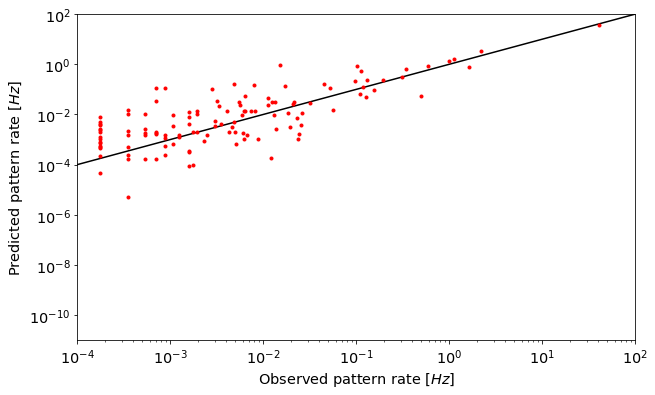

In [54]:
results_rate = np.array(results) * 50

f, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(results_rate[:,0], results_rate[:,1], 'r.')

ax.set_xlabel("Observed pattern rate $[Hz]$")
ax.set_ylabel("Predicted pattern rate $[Hz]$")
ax.set_xlim(1e-4, 1e2)
ax.set_ylim(1e-11, 1e2)
ax.set_yticks([1e2, 1e0, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10])
low, high = ax.set_xlim()
ax.plot(np.linspace(low, high), np.linspace(low, high), '-k', zorder=-1)
plt.show()

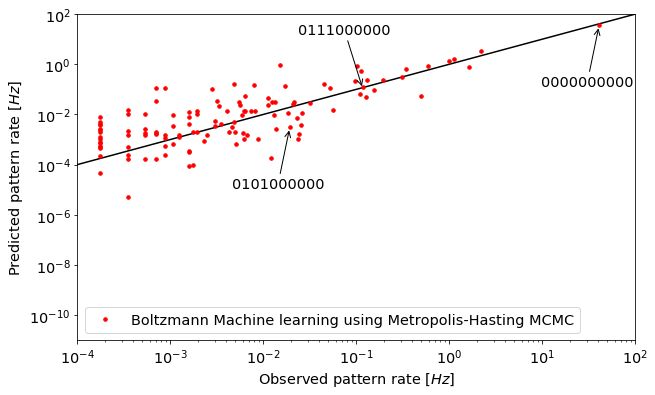

In [62]:
results_rate = np.array(results) * 50

f, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(results_rate[:,0], results_rate[:,1], 'r.',  ms=7,
        label="Boltzmann Machine learning using Metropolis-Hasting MCMC")

# anotate some patterns
for i in [0, 10]:
    pattern = "{}{}{}{}{}{}{}{}{}{}".format(*[0 if v==-1 else 1 for v in unique_mc_patterns[i]])
    ax.annotate(pattern, (results_rate[i, 0], results_rate[i, 1]*.9), 
                xytext=(results_rate[i, 0]*0.75, results_rate[i, 1]*0.01),
                ha='center', va='top', color = 'k',
                arrowprops=dict({'arrowstyle': '->'}))
for i in [14]:
    pattern = "{}{}{}{}{}{}{}{}{}{}".format(*[0 if v==-1 else 1 for v in unique_mc_patterns[i]])
    ax.annotate(pattern, (results_rate[i, 0], results_rate[i, 1]*.9), 
                xytext=(results_rate[i, 0]*2, results_rate[i, 1]*100),
                ha='right', va='bottom', color = 'k',
                arrowprops=dict({'arrowstyle': '->'}))

ax.set_xlabel("Observed pattern rate $[Hz]$")
ax.set_ylabel("Predicted pattern rate $[Hz]$")
ax.set_xlim(1e-4, 1e2)
ax.set_ylim(1e-11, 1e2)
ax.legend()
ax.set_yticks([1e2, 1e0, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10])
low, high = ax.set_xlim()
ax.plot(np.linspace(low, high), np.linspace(low, high), '-k', zorder=-1)
plt.show()